<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 100

In [ ]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if 'ResNet'  in file_name or "VGG19" in file_name:
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[7]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/400x')
df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '400x']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '400x']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 978
quantidade de dados na base de Treino 786


In [ ]:
df_treino = df_treino.drop(columns=['Magnification','DataSet','classes'])
df_treino.head()

,FikePath,Type
0,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
1,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
2,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
3,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M
4,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M


In [ ]:
df_teste = df_teste.drop(columns=['Magnification','DataSet','classes'])
df_teste.head()

,FikePath,Type
786,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M
787,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M
788,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M
789,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M
790,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M


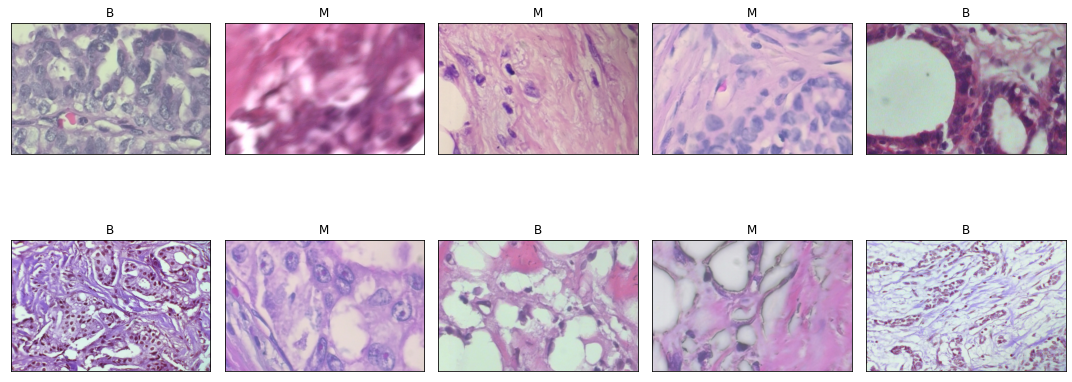

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino.shape[0]-1)
    ax.imshow(plt.imread(df_treino.FikePath[ponteiro]))
    ax.set_title(df_treino.Type[ponteiro])
plt.tight_layout()
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

In [ ]:

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)


Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [ ]:

def build_model():
    base_VGG19 = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False)
    x = base_VGG19.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_VGG19.input, outputs = preds)
    return model

In [ ]:
VGG19_rede = build_model()
VGG19_rede.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
checkpoint_path = '/content/drive/MyDrive/TCC/VGG19_MB.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [ ]:
VGG19_rede.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
history = VGG19_rede.fit(train_images, epochs=EPOCHS,validation_data=val_images,callbacks=[cp_callback])

In [ ]:
pred = VGG19_rede.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9979550102249489


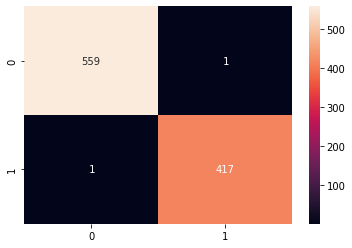

In [ ]:

print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

In [ ]:
VGG19_rede_200 = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/VGG19_MB.h5'
VGG19_rede_200.load_weights(checkpoint_path)
VGG19_rede_200.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '200x']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '200x']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 856
quantidade de dados na base de Treino 787


In [ ]:
df_treino = df_treino.drop(columns=['Magnification','DataSet','classes'])
df_teste = df_teste.drop(columns=['Magnification','DataSet','classes'])

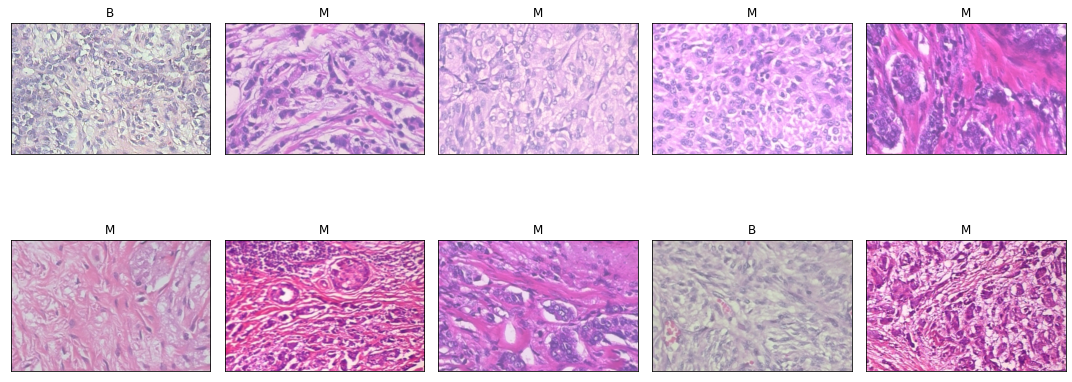

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino.shape[0]-1)
    ax.imshow(plt.imread(list(df_treino.FikePath)[ponteiro]))
    ax.set_title(list(df_treino.Type)[ponteiro])
plt.tight_layout()
plt.show()

In [ ]:

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19_rede_200.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19_rede_200.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9158878504672897


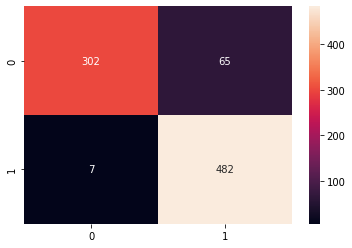

In [ ]:

print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

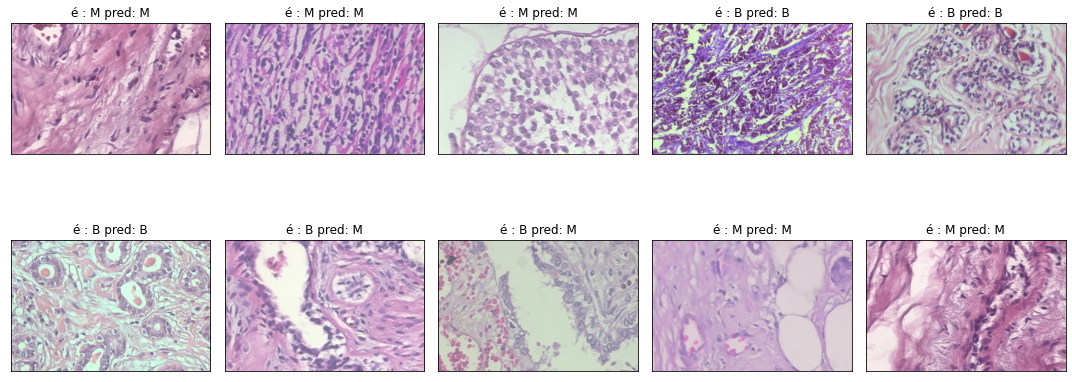

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,pred_df.shape[0]-1)
    ax.imshow(plt.imread(list(pred_df.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.Type)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()

#Tudo junto 


In [ ]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC')
df_treino = df_geral[df_geral['DataSet'] == 'Tr']
df_teste = df_geral[df_geral['DataSet'] == 'Te']

In [ ]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 2707
quantidade de dados na base de Treino 2373


In [ ]:

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 2707 validated image filenames belonging to 2 classes.


In [ ]:
opt = Adam(learning_rate=0.0001)
VGG19_rede_Geral = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/VGG19_MB.h5'
VGG19_rede_Geral.load_weights(checkpoint_path)
VGG19_rede_Geral.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
pred = VGG19_rede_Geral.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9183598079054304


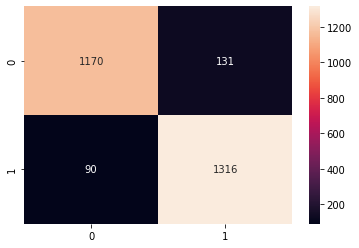

In [ ]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

#Aqui vai começar os de classes


In [2]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
EPOCHS = 25

In [3]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if 'ResNet'  in file_name or "VGG19" in file_name or "Interception" in file_name:
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')[7]
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [4]:
df_geral =  montar_data_frame(r'/content/drive/MyDrive/TCC/400x')
df_treino = df_geral[df_geral['DataSet'] == 'Tr'][df_geral['Magnification'] == '400x'][df_geral['Type'] == 'M']
df_teste = df_geral[df_geral['DataSet'] == 'Te'][df_geral['Magnification'] == '400x'][df_geral['Type'] == 'M']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
print(f'quantidade de dados na base de Teste {df_teste.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino.shape[0]}')

quantidade de dados na base de Teste 418
quantidade de dados na base de Treino 418


In [6]:

df_treino = df_treino.drop(columns=['Magnification','DataSet','Type'])
df_treino.head()

,FikePath,classes
0,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,DC
1,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,DC
2,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,DC
3,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,DC
4,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,DC


In [7]:
df_teste = df_teste.drop(columns=['Magnification','DataSet','Type'])
df_teste.head()

,FikePath,classes
786,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,DC
787,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,DC
788,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,DC
789,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,DC
790,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,DC


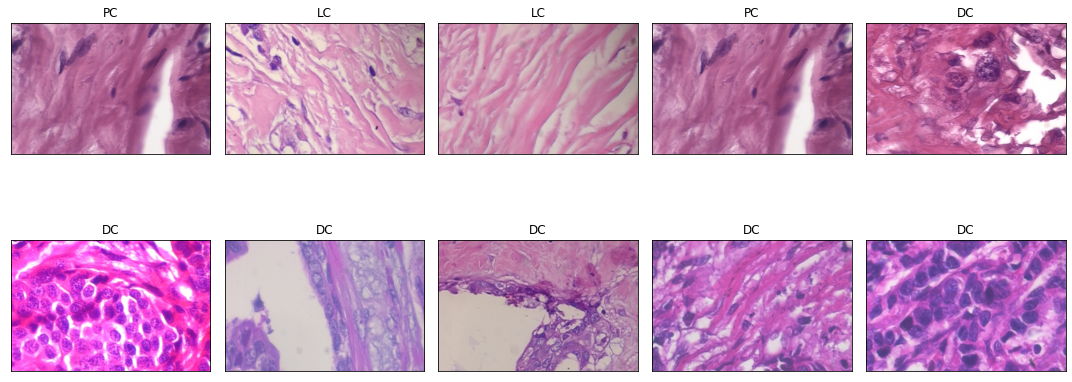

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino.shape[0]-1)
    ax.imshow(plt.imread(df_treino.FikePath[ponteiro]))
    ax.set_title(df_treino.classes[ponteiro])
plt.tight_layout()
plt.show()

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste,
    x_col='FikePath',
    y_col='classes',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 335 validated image filenames belonging to 4 classes.
Found 83 validated image filenames belonging to 4 classes.
Found 418 validated image filenames belonging to 4 classes.


In [14]:
def build_model():
    base_Interception = VGG19(weights = 'imagenet', include_top = False)
    x = base_Interception.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(4, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_Interception.input, outputs = preds)
    return model

In [15]:
vgg_class = build_model()
vgg_class.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [16]:
checkpoint_path = '/content/drive/MyDrive/TCC/VGG19_class.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

In [18]:
opt = Adam(learning_rate=0.0001)
vgg_class.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [19]:
history = vgg_class.fit(train_images, epochs=EPOCHS,validation_data=val_images,callbacks=[cp_callback,stop])

Epoch 1/25
11/11 [==============================] - 849s 75s/step - loss: 1.4033 - accuracy: 0.4657 - val_loss: 1.0045 - val_accuracy: 1.0000

Epoch 00001: saving model to /content/drive/MyDrive/TCC/VGG19_class.h5
Epoch 2/25
11/11 [==============================] - 809s 74s/step - loss: 1.3012 - accuracy: 0.4627 - val_loss: 0.7602 - val_accuracy: 1.0000

Epoch 00002: saving model to /content/drive/MyDrive/TCC/VGG19_class.h5
Epoch 3/25
11/11 [==============================] - 809s 74s/step - loss: 1.2351 - accuracy: 0.4806 - val_loss: 0.6775 - val_accuracy: 1.0000

Epoch 00003: saving model to /content/drive/MyDrive/TCC/VGG19_class.h5
Epoch 4/25
11/11 [==============================] - 809s 74s/step - loss: 1.1322 - accuracy: 0.5104 - val_loss: 0.9224 - val_accuracy: 0.7108

Epoch 00004: saving model to /content/drive/MyDrive/TCC/VGG19_class.h5
Epoch 5/25
11/11 [==============================] - 807s 73s/step - loss: 1.1758 - accuracy: 0.5552 - val_loss: 0.9304 - val_accuracy: 0.7108

E

In [22]:
pred = vgg_class.predict(test_images)
pred=np.argmax(pred,axis=1)

In [23]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9066985645933014


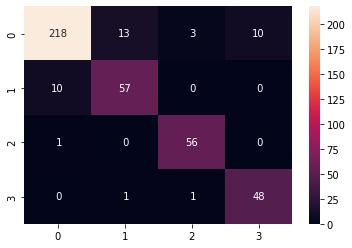

In [25]:
print(f"Accuracy Score: {accuracy_score(pred_df['classes'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['classes'],pred_df['pred']), annot=True, fmt='2d');

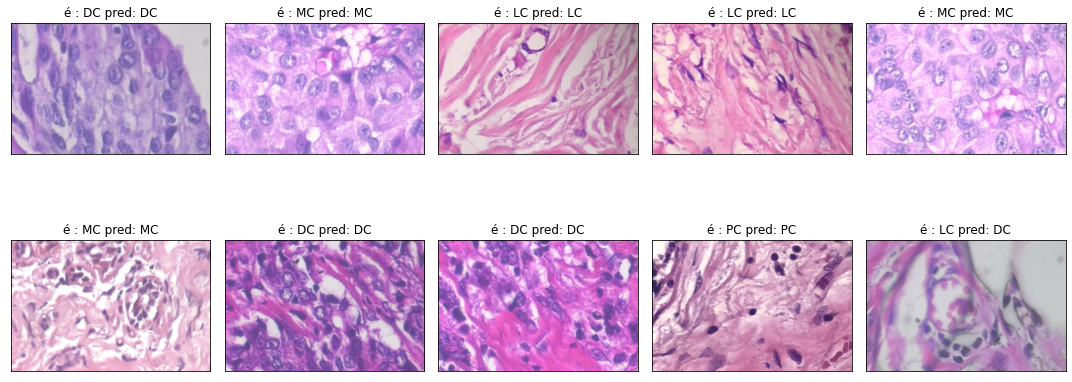

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,pred_df.shape[0]-1)
    ax.imshow(plt.imread(list(pred_df.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.classes)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()